In [2]:
from scipy.stats import norm
from pandas import DataFrame
import numpy as np
import pandas as pd

def bsCall(S, K, r, s, T):
    d1 = (np.log(S/K) + (r + 0.5*s**2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
def bsPut(S, K, r, s, T):
    d1 = (np.log(S/K) + (r + 0.5*s**2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)
    return -S*norm.cdf(-d1) + K*np.exp(-r*T)*norm.cdf(-d2)

vol = pd.read_csv('IV.csv', parse_dates=['Date']).iloc[1:, :].set_index('Date').dropna()
spx = pd.read_csv('data.csv', parse_dates=['Date'])[['Date', 'SPX']].set_index('Date')
param = pd.read_csv('LIBOR.csv', header=5, parse_dates=[0]).iloc[:, :2].set_index('Date').rename(columns={'PX_ASK': '1ML'}).merge(spx, on='Date')

dates = param.index.intersection(vol.index)
param = param.loc[dates]
param = param.assign(FWD=np.exp(param['1ML']/1200)*param['SPX'])
vol = vol.loc[dates]
strike = DataFrame(np.array([param['FWD'] + Delta for Delta in [-90, -75, -60, -50, -40, -25, -10, 0, 10, 25, 40, 50, 60, 75, 90]]).T, 
                  columns=vol.columns, index=vol.index)

In [5]:
%%time

m, n = vol.shape
pv = np.empty_like(vol)
for i in range(m):
    for j in range(n):
        pricingFnc = bsCall if vol.columns[j][0] == 'C' else bsPut
        pv[i, j] = pricingFnc(  S=param['SPX'].iloc[i], 
                                K=strike.iloc[i, j], 
                                r=param['1ML'].iloc[i]/100, 
                                s=vol.iloc[i, j]/100, 
                                T=1/12)            
        
pv = DataFrame(pv, columns=vol.columns, index=vol.index)
pv.to_csv('pv.csv')

CPU times: user 23.5 s, sys: 44.8 ms, total: 23.6 s
Wall time: 25.9 s


In [5]:
from sklearn.preprocessing import StandardScaler

pv = pd.read_csv('pv.csv', index_col=0)
pv.index = strike.index

DataFrame(StandardScaler().fit_transform(pv/(strike**2)), index=pv.index, columns=pv.columns).to_csv('features.csv')

In [6]:
import pandas as pd

df = pd.read_csv('features.csv', index_col=0)
df.describe()

,PUT_90,PUT_75,PUT_60,PUT_50,PUT_40,PUT_25,PUT_10,ATM,CALL_10,CALL_25,CALL_40,CALL_50,CALL_60,CALL_75,CALL_90
count,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03,3.994000e+03
mean,9.962542e-17,-2.846441e-17,-4.269661e-17,5.692881e-17,-5.692881e-17,-5.692881e-17,5.692881e-17,-2.277152e-16,-2.846441e-17,8.539322e-17,1.423220e-16,-8.539322e-17,-5.692881e-17,-1.138576e-16,-4.269661e-17
std,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00
min,-6.899120e-01,-4.899336e-01,-5.915494e-01,-6.631780e-01,-7.512844e-01,-8.823102e-01,-1.001736e+00,-9.218905e-01,-8.636553e-01,-8.038622e-01,-7.452979e-01,-6.969905e-01,-6.723372e-01,-6.505588e-01,-6.918048e-01
25%,-4.906359e-01,-4.141726e-01,-4.521692e-01,-4.744338e-01,-4.928146e-01,-5.028036e-01,-5.263693e-01,-5.373715e-01,-5.155881e-01,-4.951930e-01,-4.953181e-01,-4.890756e-01,-4.838599e-01,-4.790884e-01,-4.870686e-01
50%,-3.156299e-01,-3.063464e-01,-3.061197e-01,-3.042888e-01,-3.095806e-01,-3.117710e-01,-3.167147e-01,-2.989564e-01,-3.000858e-01,-3.154987e-01,-3.121267e-01,-3.061271e-01,-3.069733e-01,-3.066214e-01,-2.978659e-01
75%,1.217519e-01,1.176072e-02,4.524335e-02,6.800973e-02,7.784223e-02,9.217585e-02,1.296520e-01,1.279033e-01,1.121031e-01,7.431735e-02,7.745063e-02,8.503045e-02,7.615577e-02,6.375091e-02,7.451197e-02
max,1.076231e+01,1.381078e+01,1.201785e+01,1.108982e+01,1.031481e+01,9.407108e+00,8.362852e+00,8.175289e+00,9.465249e+00,1.017973e+01,1.062080e+01,1.088049e+01,1.112761e+01,1.149175e+01,1.101581e+01


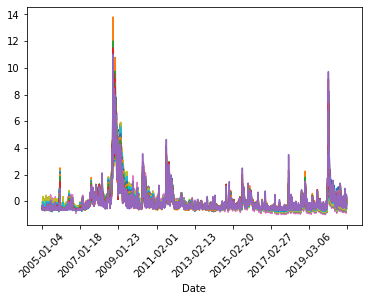

In [7]:
df = pd.read_csv('features.csv', index_col=0)

df.plot(rot=45, legend=None)
pass